In [1]:
import pandas as pd
import numpy as np
import locationtagger
from geotext import GeoText
from textblob import TextBlob
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from operator import itemgetter

In [2]:
air = pd.read_csv('AirCanada_review_raw.csv')

In [3]:
air = air.drop(axis=1, columns=['Unnamed: 0','page'])
air.fillna("", inplace = True)

In [4]:
def get_cities(text):
    if len(text)==0:
        return []
    places = GeoText(text)
    return places.cities

air['cities'] = air['Route'].apply(get_cities)

In [5]:
city = []

def unique_cities(cities):
    for a in cities:
        if a.lower() not in city:
            city.append(a.lower())
            
air['cities'].apply(unique_cities)

0       None
1       None
2       None
3       None
4       None
        ... 
1639    None
1640    None
1641    None
1642    None
1643    None
Name: cities, Length: 1644, dtype: object

In [6]:
def len_list(text):
    return len(text)

air['len_cities'] = air['cities'].apply(len_list)

In [7]:
air['sum_ratings'] = air.where(air[['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Ground Service', 'Wifi & Connectivity', 'Value For Money']] > 0).sum(1)
air['count_ratings'] = air.where(air[['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Ground Service', 'Wifi & Connectivity', 'Value For Money']] > 0).count(1)
air['avg_rating'] = air['sum_ratings']/air['count_ratings']

In [25]:
air.head()

,title,user,user_type,review,publish_date,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,...,cities,len_cities,sum_ratings,count_ratings,avg_rating,title_blob,review_blob,review_tokens,title_tokens,review_sent
0,24 hour delay which was not acceptable,Tony Harris,TripVerified,Flight from Sydney to Montreal cancelled on ...,6th February 2022,Business,Economy Class,Toronto to Vancouver,February 2022,1,...,"[Toronto, Vancouver]",2,4.0,4,1.000000,0.0,0.002222,"[montreal, cancelled, february, automatically,...","[hour, delay, acceptable]",pos
1,Worst airline ever,S Deane,TripVerified,Air Canada’s website booked me with another ...,3rd February 2022,Solo Leisure,Economy Class,Tokyo to Seattle via Seoul / Vancouver,February 2022,0,...,"[Tokyo, Seattle, Seoul, Vancouver]",4,1.0,1,1.000000,-1.0,-0.017857,"[website, booked, another, airline, connect, a...","[worst, airline, ever]",neg
2,the staff had no power to act,Collins Mazraani,TripVerified,I had booked business class for my mother an...,27th January 2022,Family Leisure,Economy Class,London to Montreal,January 2022,2,...,[London],1,15.0,7,2.142857,0.0,-0.002381,"[booked, business, class, mother, booked, econ...","[staff, power, act]",neg
3,Absolutely the worst airline,Shawn Holden,NotVerified,Houston to Prince George. They cancelled my f...,25th January 2022,Family Leisure,Economy Class,Houston to Prince George,February 2021,1,...,"[Houston, Prince George]",2,4.0,4,1.000000,-0.4,-0.042500,"[prince, george, cancelled, prince, george, ti...","[absolutely, worst, airline]",neg
4,I was not reimbursed for charges,G Ragami,TripVerified,Air Canada cancelled my flights twice so I h...,18th January 2022,Solo Leisure,Economy Class,Saskatoon to Chicago via Toronto,December 2021,2,...,"[Saskatoon, Chicago, Toronto]",3,8.0,5,1.600000,0.0,-0.050000,"[cancelled, twice, pay, additional, charges, c...","[reimbursed, charges]",neg


In [8]:
def get_blob(lemma):
    return TextBlob(lemma).sentiment[0]

air['title_blob'] = air['title'].apply(get_blob)
air['review_blob'] = air['review'].apply(get_blob)

In [9]:
stop_words = stopwords.words('english')
newStopWords = ['air', 'canada', 'even', 'also', 'us', 'would', 'could', 'get', 'got', 'go', 'flight', 'flights', 'said', 'next', 'one', 'two', 'made', 'however', 'went', 'without', 'say', 'said']

In [10]:
def get_tokens(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in stop_words and word.isalpha() and word.lower() not in city and word.lower() not in newStopWords:
            newlist.append(word.lower())
    return newlist

In [11]:
air['review_tokens'] = air['review'].apply(get_tokens)
air['title_tokens'] = air['title'].apply(get_tokens)

In [12]:
def build_word_freq(pos_list, neg_list):
    freq_dict={}
    for token_list in pos_list:
        for token in token_list:
            if (token, 1) not in freq_dict.keys():
                freq_dict[(token, 1)] = 1
            else:
                freq_dict[(token, 1)] = freq_dict[(token, 1)] + 1
    for token_list in neg_list:
        for token in token_list:
            if (token, 0) not in freq_dict.keys():
                freq_dict[(token, 0)] = 1
            else:
                freq_dict[(token, 0)] = freq_dict[(token, 0)] + 1  
    return freq_dict

In [13]:
#building frequency dictionary for each token with a particular label
frequency_dict_review = build_word_freq(air.loc[air['review_blob'] > 0, 'review_tokens'].tolist(), air.loc[air['review_blob'] < 0, 'review_tokens'].tolist())
frequency_dict_title = build_word_freq(air.loc[air['title_blob'] > 0, 'title_tokens'].tolist(), air.loc[air['title_blob'] < 0, 'title_tokens'].tolist())

In [14]:
sorted(frequency_dict_review.items(),key=itemgetter(1), reverse = True)

[(('service', 1), 795),
 (('time', 1), 690),
 (('good', 1), 574),
 (('seat', 1), 543),
 (('seats', 1), 461),
 (('food', 1), 459),
 (('ac', 1), 426),
 (('staff', 1), 419),
 (('plane', 1), 399),
 (('crew', 1), 391),
 (('service', 0), 352),
 (('hours', 1), 351),
 (('class', 1), 332),
 (('economy', 1), 330),
 (('told', 1), 327),
 (('back', 1), 325),
 (('fly', 1), 325),
 (('cabin', 1), 321),
 (('airport', 1), 312),
 (('business', 1), 300),
 (('airline', 1), 293),
 (('hour', 1), 291),
 (('first', 1), 286),
 (('time', 0), 278),
 (('boarding', 1), 277),
 (('passengers', 1), 275),
 (('experience', 1), 273),
 (('hours', 0), 272),
 (('luggage', 1), 259),
 (('new', 1), 255),
 (('delayed', 1), 252),
 (('customer', 1), 250),
 (('staff', 0), 244),
 (('great', 1), 242),
 (('montreal', 1), 241),
 (('plane', 0), 239),
 (('gate', 1), 232),
 (('entertainment', 1), 231),
 (('flew', 1), 223),
 (('way', 1), 219),
 (('check', 1), 218),
 (('seat', 0), 213),
 (('another', 1), 212),
 (('airline', 0), 212),
 (('f

In [15]:
pos_review = []
neg_review = []
for k, v in frequency_dict_review:
    if v == 1:
        pos_review.append((k,frequency_dict_review[(k,v)]))
    else:
        neg_review.append((k,frequency_dict_review[(k,v)]))

In [16]:
sorted(neg_review,key=itemgetter(1), reverse = True)

[('service', 352),
 ('time', 278),
 ('hours', 272),
 ('staff', 244),
 ('plane', 239),
 ('seat', 213),
 ('airline', 212),
 ('food', 198),
 ('customer', 196),
 ('airport', 196),
 ('told', 182),
 ('seats', 175),
 ('hour', 172),
 ('delayed', 165),
 ('passengers', 160),
 ('back', 160),
 ('never', 142),
 ('montreal', 139),
 ('due', 133),
 ('gate', 127),
 ('experience', 127),
 ('ac', 126),
 ('minutes', 115),
 ('day', 114),
 ('luggage', 113),
 ('another', 109),
 ('late', 109),
 ('fly', 109),
 ('boarding', 108),
 ('via', 107),
 ('worst', 107),
 ('business', 106),
 ('meal', 106),
 ('baggage', 106),
 ('asked', 105),
 ('crew', 103),
 ('return', 99),
 ('trip', 99),
 ('class', 97),
 ('rude', 95),
 ('arrived', 94),
 ('way', 92),
 ('take', 90),
 ('hotel', 90),
 ('still', 90),
 ('economy', 89),
 ('long', 89),
 ('people', 88),
 ('later', 87),
 ('bag', 83),
 ('flying', 82),
 ('first', 81),
 ('new', 80),
 ('cancelled', 79),
 ('poor', 79),
 ('flew', 79),
 ('bad', 79),
 ('airlines', 79),
 ('last', 78),
 ('h

In [17]:
sorted(frequency_dict_title.items(),key=itemgetter(1), reverse = True)

[(('service', 0), 54),
 (('good', 1), 50),
 (('service', 1), 50),
 (('experience', 1), 34),
 (('customer', 0), 30),
 (('experience', 0), 27),
 (('friendly', 1), 26),
 (('worst', 0), 26),
 (('crew', 1), 24),
 (('staff', 1), 22),
 (('terrible', 0), 22),
 (('cabin', 1), 21),
 (('great', 1), 20),
 (('excellent', 1), 18),
 (('poor', 0), 17),
 (('airline', 0), 15),
 (('seats', 0), 15),
 (('professional', 1), 14),
 (('pleasant', 1), 14),
 (('attentive', 1), 13),
 (('uncomfortable', 0), 13),
 (('seat', 0), 13),
 (('comfortable', 1), 12),
 (('best', 1), 11),
 (('rude', 0), 11),
 (('disappointed', 0), 11),
 (('fly', 1), 10),
 (('late', 0), 10),
 (('food', 0), 10),
 (('food', 1), 9),
 (('helpful', 1), 9),
 (('horrible', 0), 9),
 (('staff', 0), 9),
 (('extremely', 0), 9),
 (('bad', 0), 8),
 (('due', 0), 8),
 (('overall', 1), 7),
 (('seats', 1), 7),
 (('new', 1), 7),
 (('enjoyable', 1), 7),
 (('attendants', 1), 7),
 (('absolutely', 0), 7),
 (('tight', 0), 7),
 (('really', 1), 6),
 (('airline', 1), 

In [18]:
pos_title = []
neg_title = []
for k, v in frequency_dict_title:
    if v == 1:
        pos_title.append((k,frequency_dict_title[(k,v)]))
    else:
        neg_title.append((k,frequency_dict_title[(k,v)]))

In [19]:
sorted(neg_title,key=itemgetter(1), reverse = True)

[('service', 54),
 ('customer', 30),
 ('experience', 27),
 ('worst', 26),
 ('terrible', 22),
 ('poor', 17),
 ('airline', 15),
 ('seats', 15),
 ('uncomfortable', 13),
 ('seat', 13),
 ('rude', 11),
 ('disappointed', 11),
 ('late', 10),
 ('food', 10),
 ('horrible', 9),
 ('staff', 9),
 ('extremely', 9),
 ('bad', 8),
 ('due', 8),
 ('absolutely', 7),
 ('tight', 7),
 ('awful', 6),
 ('weather', 6),
 ('never', 5),
 ('average', 5),
 ('hard', 5),
 ('limited', 5),
 ('cancelled', 5),
 ('ground', 5),
 ('disappointment', 5),
 ('poorly', 5),
 ('appalling', 5),
 ('ever', 4),
 ('frustrating', 4),
 ('business', 4),
 ('class', 4),
 ('cold', 4),
 ('far', 4),
 ('space', 4),
 ('fly', 4),
 ('incompetent', 4),
 ('really', 4),
 ('cabin', 3),
 ('wrong', 3),
 ('attendants', 3),
 ('unpleasant', 3),
 ('check', 3),
 ('missing', 3),
 ('luggage', 3),
 ('delayed', 3),
 ('money', 3),
 ('narrow', 3),
 ('worth', 3),
 ('overall', 3),
 ('disappointing', 3),
 ('hour', 3),
 ('helpful', 3),
 ('least', 2),
 ('organization', 2),

In [20]:
air.loc[air['review_blob'] > 0, 'review_sent'] = 'pos'
air.loc[air['review_blob'] < 0, 'review_sent'] = 'neg'

<AxesSubplot:xlabel='Seat Comfort', ylabel='Count'>

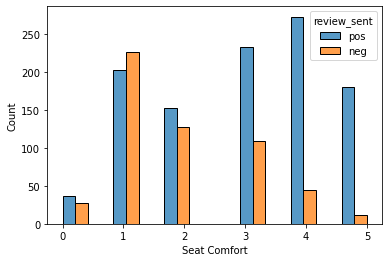

In [21]:
sns.histplot(data=air, x="Seat Comfort", hue="review_sent", multiple="dodge")

<AxesSubplot:xlabel='Food & Beverages', ylabel='Count'>

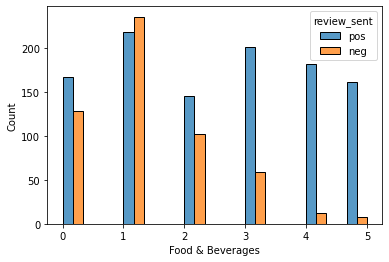

In [22]:
sns.histplot(data=air, x="Food & Beverages", hue="review_sent", multiple="dodge")

<AxesSubplot:xlabel='Cabin Staff Service', ylabel='Count'>

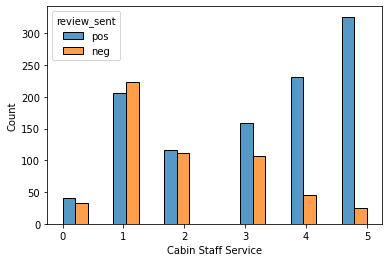

In [23]:
sns.histplot(data=air, x="Cabin Staff Service", hue="review_sent", multiple="dodge")

<AxesSubplot:xlabel='Wifi & Connectivity', ylabel='Count'>

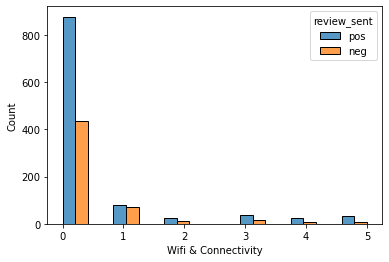

In [24]:
sns.histplot(data=air, x="Wifi & Connectivity", hue="review_sent", multiple="dodge")

In [26]:
air.to_csv('air_canada_blob_&_tokens.csv', index=False)